From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
epsilons = [0.1]#[0, .05, .1, .15, .2, .25, .3]
pretrained_model = "models\simple_FashionMNIST.pth"#"data/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [6]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
# import sys
# import os
# current_dir = os.getcwd()

# # Assuming the Jupyter Notebook is in the 'experiments' directory
# # and the 'models' directory is at the same level as 'experiments'
# parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# # Add the parent directory to the Python path
# sys.path.append(parent_dir)
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Running on cpu.
Model weights loaded successfully


In [14]:
for image, target in target_mdl.testloader:
    print(image.shape)
    print(torch.min(image), torch.max(image))
    break

torch.Size([1, 1, 28, 28])
tensor(0.) tensor(1.)


In [6]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)
    if target_mdl.requires_denorm:
        return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
    else:
        return batch

In [7]:
class stepsize():
    def __init__(self, strat, fixed_size = 1, ls_model=None, ls_criterion=None, ls_target = None, ls_num_samples=10):
        if isinstance(strat, (float, int)):
            fixed_size = strat
            strat = 'fixed'
        self.strat = strat
        self.fixed_size = fixed_size
        self.ls_model = ls_model
        self.ls_criterion = ls_criterion
        self.ls_target = ls_target
        self.ls_num_samples = ls_num_samples
        self.stepsize = fixed_size # will be updated if using other method
        if self.strat not in ['fixed', 'ls', 'decay']:
            raise Exception("Accepted stepsize rules are ['fixed', 'ls', 'decay']")
    
    def set_stepsize_decay(self, t):
        self.stepsize = 2 / (t + 2)
        return

    def stepsize_linesearch(self, x_t, d_t):
        x_tc = x_t.clone().detach()
        d_tc = d_t.clone().detach()
        losses = []
        with torch.no_grad():
            steps = [(i + 1) / self.ls_num_samples for i in range(self.ls_num_samples)]
            for step in steps:
                output = model(x_tc + step * d_tc)
                losses.append(self.ls_criterion(output, self.ls_target))
        best_idx = np.argmin(losses) # check if this is min or max
        self.stepsize = steps[best_idx]
        return self.stepsize
    

In [8]:
def fw_step(x_t, epsilon, g_t, x0, stepsize_method):
    # alg from attacks.pdf. Modified to remove momentum.
    g_t_sign = g_t.sign()
    v_t = -epsilon * g_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    #gap_FW = torch.sum(d_t * g_t).item()#torch.dot(d_t, g_t)
    gap_FW = torch.sum(-d_t * g_t).item()
    return perturbed_image, gap_FW

def fw_step_altgap(x_t, epsilon, g_t, x0, stepsize_method):
    # alg from attacks.pdf. Modified to remove momentum.
    g_t_sign = g_t.sign()
    v_t = -epsilon * g_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    #gap_FW = torch.sum(d_t * g_t).item()#torch.dot(d_t, g_t)
    #gap_FW = torch.sum(-d_t * g_t).item()
    gap_FW = torch.sum(-(perturbed_image - x_t)*g_t).item()
    return perturbed_image, gap_FW

def fw_step_momentum(x_t, epsilon, g_t, m_t_last, x0, stepsize_method, momentum = 0.2):
    # alg from attacks.pdf
    m_t = (1 - momentum)*g_t
    if m_t_last is not None:
        m_t += momentum*m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    gap_FW = torch.sum(-d_t * g_t).item()
    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t, gap_FW

def fw_step_momentum1(x_t, epsilon, g_t, m_t_last, x0, momentum = 0.2,fw_stepsize = 1):
    # alg from attacks.pdf
    m_t = (1 - momentum)*g_t
    if m_t_last is not None:
        m_t += momentum*m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t
    perturbed_image = x_t - momentum * epsilon * m_t_sign - momentum * (x_t - x0)#x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t


def fw_step_pairwise():
    # alg from FW_varients.pdf
    return

In [9]:
def fw_step_away(x_t, epsilon, g_t, x0, S_t):
    info = {}
    # alg from FW_varients.pdf
    # FW direction
    g_t_sign = g_t.sign()
    s_t = -epsilon * g_t_sign + x0
    d_t_FW = s_t - x_t
    # AWAY direction. From set of vertices already visited
    away_costs = []
    for v in S_t:
        away_costs.append(torch.sum(g_t*v).item())
    v_t_idx = np.argmax(away_costs)
    v_t = S_t[v_t_idx]
    # at each iter x_t expressed by convex combination of active verticies
    #alpha_v_t = alphas_t[v_t_idx]
    d_t_AWAY = x_t - v_t
    #check optimality (FW gap)
    gap_FW = torch.sum(-g_t * d_t_FW).item()
    gap_AWAY = torch.sum(-g_t*d_t_AWAY).item()
    info['gap_FW'] = gap_FW
    info['gap_AS'] = gap_AWAY

    
    # check which direction is closer to the gradient
    if gap_FW >= gap_AWAY:
        info['step'] = 'FW'
        info['S_idx'] = -1 #idicate last vertex is S_t is used which is the current FW direction
        d_t = d_t_FW
        max_step = 1
        S_t.append(d_t.clone().detach())
    else:
        info['step'] = 'AS'
        info['S_idx'] = v_t_idx
        d_t = d_t_AWAY
        alpha_v_t = 0.1 # REMOVE ME or implement line searching or solve system to get alpha coeffs
        max_step = 0.1 #alpha_v_t / (1 - alpha_v_t) # this is a safe step size to remain in C. Need to verify this

    # line-search for the best gamma (FW stepsize)
    perturbed_image = x_t + max_step * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, S_t, info


In [10]:
class AdversarialLoss(nn.Module):
    def __init__(self, num_classes, specific_label=None):
        """
        Initialize the AdversarialLoss.
        
        Args:
        - num_classes (int): Total number of classes in the classification problem.
        - specific_label (int, optional): A specific incorrect label to target. If None, the loss will consider all incorrect labels.
        """
        super(AdversarialLoss, self).__init__()
        self.num_classes = num_classes
        self.specific_label = specific_label

    def forward(self, outputs, targets):
        """
        Compute the adversarial loss.
        
        Args:
        - outputs (torch.Tensor): The model outputs (logits) of shape (batch_size, num_classes).
        - targets (torch.Tensor): The true labels of shape (batch_size,).
        
        Returns:
        - loss (torch.Tensor): The computed adversarial loss.
        """
        batch_size = outputs.size(0)
        if self.specific_label is not None:
            # Targeting a specific incorrect label
            incorrect_labels = torch.full_like(targets, self.specific_label)
            mask = (incorrect_labels != targets).float()
            specific_log_probs = F.log_softmax(outputs, dim=1).gather(1, incorrect_labels.unsqueeze(1)).squeeze(1)
            loss = -specific_log_probs * mask
            return loss.mean()
        else:
            # Averaging over all incorrect labels
            log_probs = F.log_softmax(outputs, dim=1)
            incorrect_log_probs = log_probs.clone()
            correct_log_probs = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
            for i in range(batch_size):
                incorrect_log_probs[i, targets[i]] = float('-inf')
            average_incorrect_log_probs = incorrect_log_probs.logsumexp(dim=1) - torch.log(torch.tensor(self.num_classes - 1, dtype=torch.float))
            loss = -average_incorrect_log_probs
            return loss.mean()

In [11]:
def test_fw(model, device, test_loader, epsilon,num_fw_iter, num_test = 1000, method='fw', early_stopping = None, fw_stepsize_rule = 1, gap_FW_tol = 0.05):

    # Accuracy counter
    correct = 0
    adv_examples = []
    hist = []
    ex_num = 0
    # Loop over all examples in test set
    for x0, target in test_loader:

        x_t = x0.detach().clone().to(device)  # Clone and move to device
        # Send the data and label to the device
        x0, target = x0.to(device), target.to(device)
        x0_denorm = denorm(x0)
        #x_t.requires_grad = True  #Set requires_grad attribute of tensor. Important for Attack
        m_t_last = None # gradient from previous iter
        had_first_success = False
        gap_FW = None
        S_t = [x0_denorm]
        info = None
        criterion = AdversarialLoss(10)
        stepsize_method = stepsize(fw_stepsize_rule, ls_model=model, ls_criterion=criterion, ls_target=target)

        for t in range(num_fw_iter):
            # Step size calculation
            if stepsize_method.strat == 'decay':
                stepsize_method.set_stepsize_decay(t)
            x_t.requires_grad = True
            # Forward pass the data through the model
            output = model(x_t)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, don't bother attacking, just move on
            if (init_pred.item() != target.item()) and (t == 0):
                break

            # Calculate the loss
            loss = criterion(output, target)
            #1 - F.nll_loss(output, target) # DNN maximizing POSITIVE log liklihood
            #criterion = nn.CrossEntropyLoss()
            #loss = criterion(output, target)
            #loss = untargeted_attack_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()
            x_t_grad = x_t.grad#.data

            # Restore the data to its original scale
            x_t_denorm = denorm(x_t)

            # Call Attack
            if method == 'fgsm':
                perturbed_image = fgsm_attack(x_t_denorm, epsilon, x_t_grad)
            elif method == 'fw':
                perturbed_image, gap_FW = fw_step(x_t_denorm, epsilon, x_t_grad, x0_denorm, stepsize_method=stepsize_method)
            elif method == 'fw_altgap':
                perturbed_image, gap_FW = fw_step_altgap(x_t_denorm, epsilon, x_t_grad, x0_denorm, stepsize_method=stepsize_method)
            elif method == 'fw_AWAY':
                perturbed_image, S_t, info = fw_step_away(x_t_denorm, epsilon, x_t_grad, x0_denorm, S_t)
            elif method == 'fw_momentum':
                perturbed_image, m_t_last, gap_FW = fw_step_momentum(x_t_denorm, epsilon, x_t_grad, m_t_last, x0_denorm, stepsize_method=stepsize_method)
            # Reapply normalization
            x_t = transforms.Normalize((0.1307,), (0.3081,))(perturbed_image).detach()

            # Re-classify the perturbed image
            x_t.requires_grad = False
            output = model(x_t)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                success = False
                first_success = False
                # if t == num_fw_iter - 1:
                #     correct += 1
                # Special case for saving 0 epsilon examples
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) ) 
            else:
                first_success =  not had_first_success
                had_first_success = True
                success = True
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                #break # early stopping if attack sucessful, paper doesn't use this so I wont.
            hist_iter = {
                'example_idx':ex_num,
                'FW_iter': t + 1, # original example is 0
                'gap_FW': gap_FW if gap_FW is not None else None,
                'success': success,
                'first_success': first_success
            }
            if info is not None:
                hist_iter.update(info) # some methods output dict containing info at each step
            hist.append(hist_iter)
            if (early_stopping == 'pred') and first_success:
                # The attack was successful so the classification was not correct
                break
            elif (early_stopping == 'gap_FW') and (gap_FW < gap_FW_tol):
                if not success: # attack failed
                    correct +=1
                break
            elif (t == num_fw_iter - 1): # Stop condition: Hit max FW iters
                if not success: # attack failed
                    correct +=1

        ex_num += 1
        if ex_num >= num_test: # limit test set for speed
            break

    # Calculate final accuracy for this epsilon
    final_acc = correct/num_test
    print(f"Epsilon: {epsilon}\tCorrect Classifications (Failed Attacks) = {correct} / {num_test} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, pd.DataFrame(hist)

In [43]:
import torch
rn = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

c:\Source\Anaconda\envs\Frank\Lib\site-packages\torch\hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to C:\Users\JIC/.cache\torch\hub\master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to C:\Users\JIC/.cache\torch\hub\checkpoints\cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M 

In [46]:
from torchsummary import summary
summary(rn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [37]:
accuracies = []
examples = []
fw_iters = [5]
eps = 0.07# * (0.4242129623889923 + 2.821486711502075)
adv_examples = []
hist = None
# Run test for each epsilon
#for eps in epsilons:
for num_fw_iter in fw_iters:
    acc, ex, hist = test_fw(model, device, test_loader, eps, num_fw_iter, method='fw', early_stopping='gap_FW', fw_stepsize_rule=1, gap_FW_tol=0.1)
    accuracies.append(acc)
    examples.append(ex)
hist

Epsilon: 0.07	Correct Classifications (Failed Attacks) = 231 / 1000 = 0.231


,example_idx,FW_iter,gap_FW,success,first_success
0,0,1,6.753546e+01,True,True
1,0,2,-1.681558e-44,True,False
2,1,1,3.353384e+01,True,True
3,1,2,3.194019e-01,True,False
4,1,3,-2.051908e-06,True,False
...,...,...,...,...,...
2708,998,1,7.912377e+01,True,True
2709,998,2,5.403092e-12,True,False
2710,999,1,5.972494e+01,True,True
2711,999,2,1.106958e+00,True,False


<Axes: xlabel='FW_iter'>

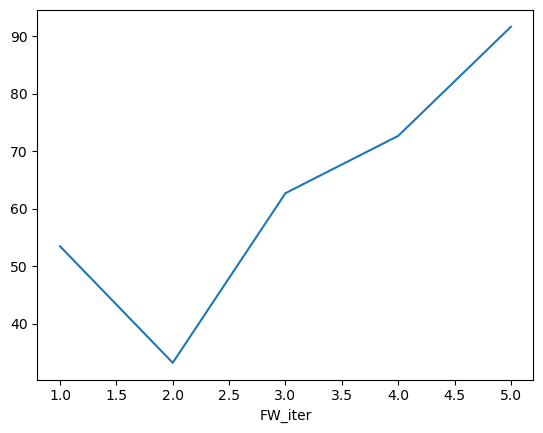

In [38]:
hist.groupby('FW_iter')['gap_FW'].mean().plot()

In [39]:
hist.groupby('example_idx').size()

example_idx
0      2
1      3
2      3
3      2
4      5
      ..
993    2
995    2
996    5
998    2
999    3
Length: 901, dtype: int64

Mean FW iterations: 2.871254162042175


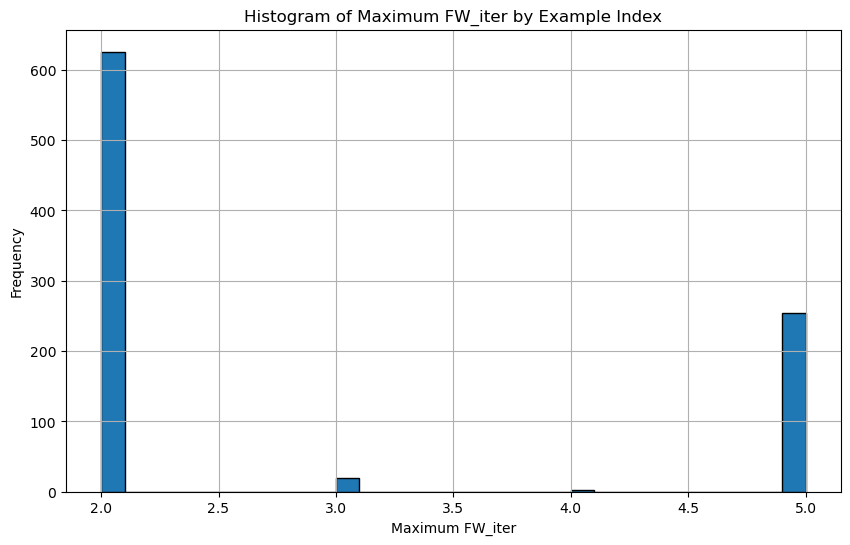

In [32]:
num_iters = hist.groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Maximum FW_iter by Example Index')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [57]:
hist['S_idx'].unique()

array([-1,  0], dtype=int64)

In [75]:
hist.groupby('step').size()

step
AS      56
FW    5187
dtype: int64

In [34]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.12874583795782463

In [35]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.0

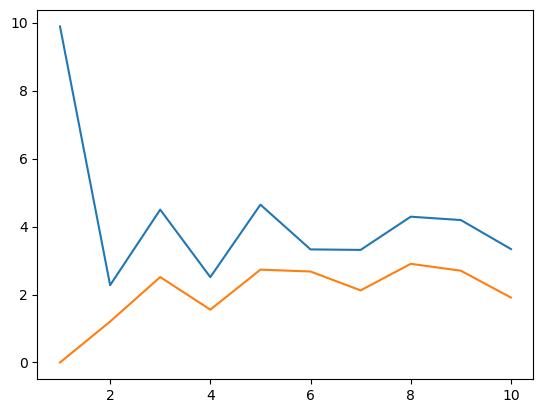

In [72]:
plt.plot(hist[hist['first_success']].groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist[hist['first_success']].groupby('FW_iter')['gap_AS'].mean())

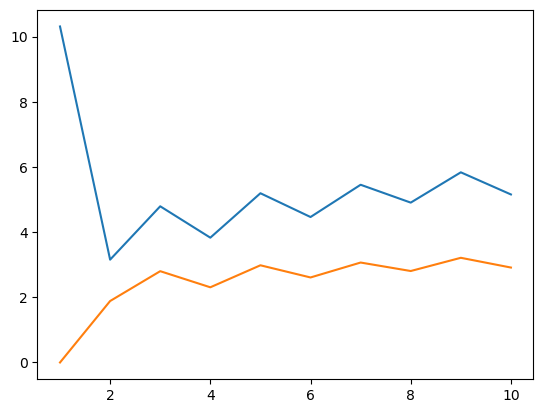

In [74]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

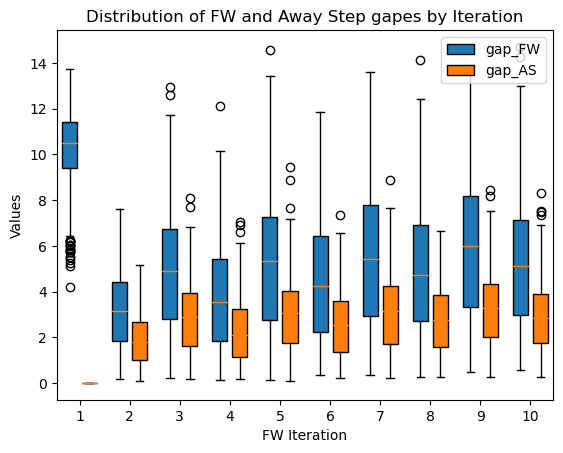

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


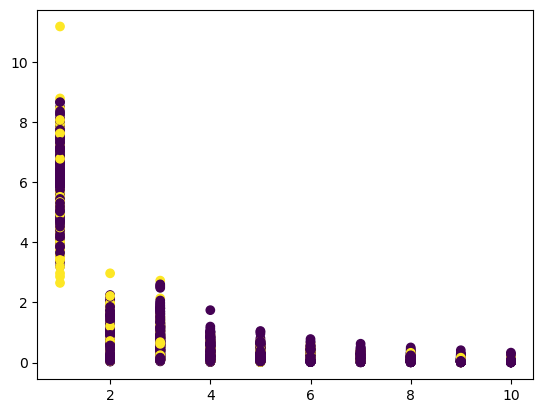

In [128]:
plt.scatter(hist['FW_iter'],hist['gap_FW'], c=hist['success'])

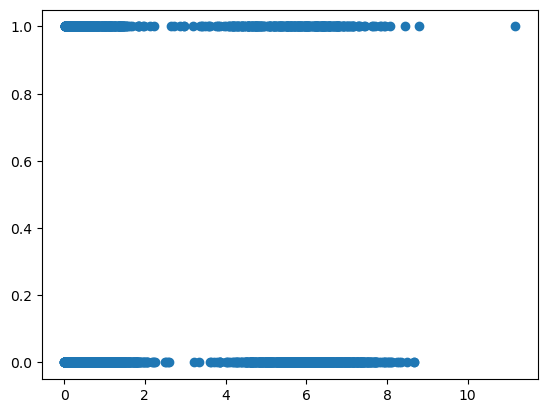

In [129]:
plt.scatter(hist['gap_FW'], hist['success'])

In [17]:
hist['gap_trans'] = np.exp(-hist['FW_gap'])

In [130]:
hist.groupby('success')['gap_FW'].mean()

success
False    1.417710
True     2.583606
Name: gap_FW, dtype: float64

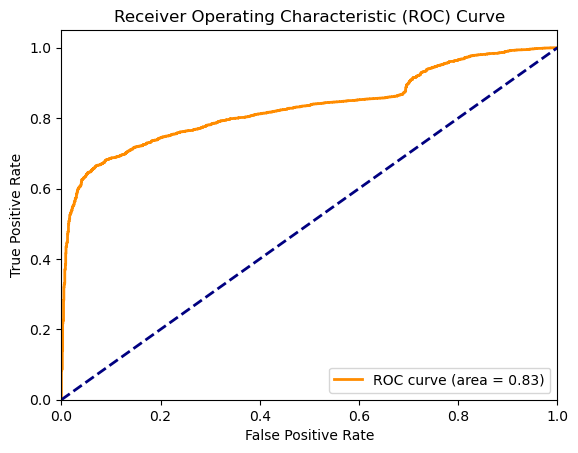

In [23]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

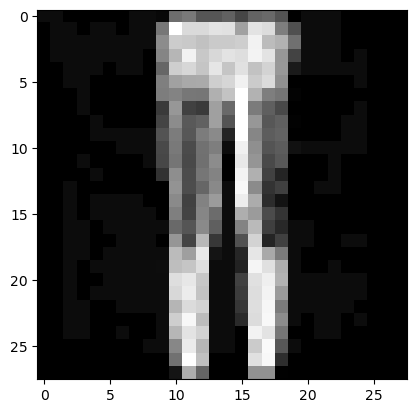

In [20]:
plt.imshow(ex[1][2], cmap='gray')

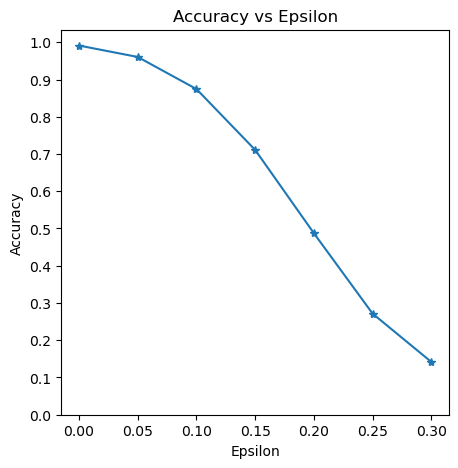

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

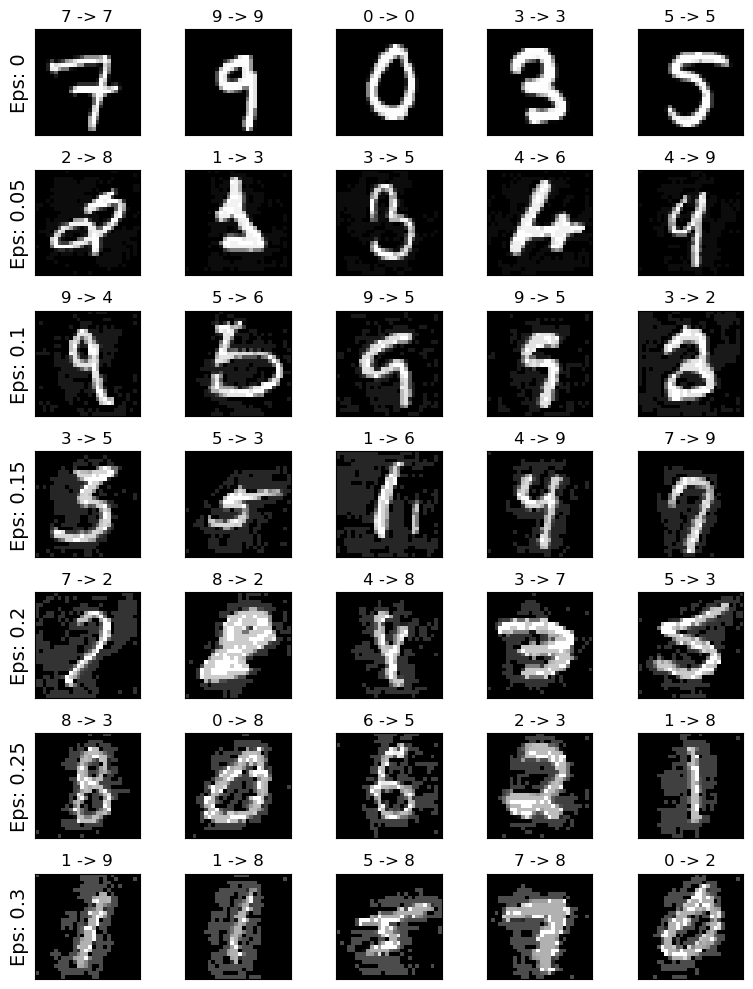

In [18]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()